In [1]:
%matplotlib inline
from __future__ import division, print_function, absolute_import
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from numpy.linalg import norm
import math
from ssvmimp.imp_scores_helper import ImportanceScoresHelper

In [2]:
points = np.load("UpperRightQuadrant.Points.1000.npy")
labels = np.load("UpperRightQuadrant.Labels.1000.npy")

In [3]:
points

array([[ -1., -48.],
       [-25.,   8.],
       [-37.,  43.],
       ..., 
       [  8., -37.],
       [-11.,  25.],
       [ 13.,  24.]])

In [4]:
#print(points)
#print(labels)
#print(points[:-100,:].shape)

# Number of support vectors:
| C        | Gamma    | Number of Support Vectors | Accuracy | Comments |
|----------|----------|---------------------------|----------|----------|
|100       | 0.001    | 18                        | 1.00     | BEST     |

In [5]:
gamma=0.001
clf = SVC(C=100, gamma=gamma)
print(clf)
clf.fit(points[:-100,:], labels[:-100])

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [6]:
numcorrect = 0
for (point, label) in zip(points[-100:,:], labels[-100:]):
    prediction = clf.predict([point])
#    print("Point: " + str(point) + " Label: " + str(label) + " Prediction: " + str(prediction))
    if label == prediction:
        numcorrect += 1
    else:
        print("INACCURATE PREDICTION!!: Point: " + str(point) + " Label: " + str(label) + " Prediction: " + str(prediction))
print("Accuracy: " + str(float(numcorrect)/100.0))

Accuracy: 1.0


In [7]:
#print(clf.support_.shape)

In [8]:
print(str(clf.support_vectors_.shape))

(18, 2)


In [9]:
prediction_at_support = np.empty(clf.support_vectors_.shape[0])
i = 0
for (x, y) in clf.support_vectors_:
    prediction_at_support[i] = clf.predict([[x,y]])
    i += 1
print(prediction_at_support.shape)
print(prediction_at_support)

(18,)
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.]


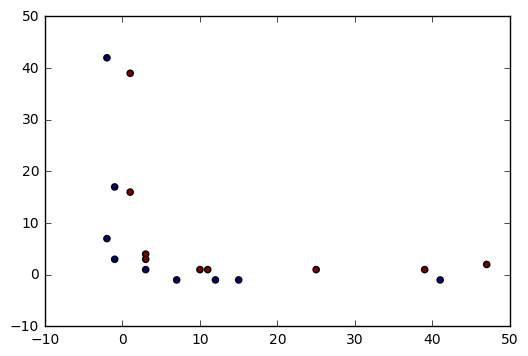

In [10]:
plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], c=prediction_at_support[:] )
plt.show()

In [11]:
clf.support_vectors_

array([[ 12.,  -1.],
       [ -2.,   7.],
       [ 15.,  -1.],
       [ 41.,  -1.],
       [  7.,  -1.],
       [ -2.,  42.],
       [ -1.,   3.],
       [ -1.,  17.],
       [  1.,  16.],
       [  3.,   4.],
       [ 11.,   1.],
       [ 25.,   1.],
       [  3.,   1.],
       [  1.,  39.],
       [ 10.,   1.],
       [ 39.,   1.],
       [ 47.,   2.],
       [  3.,   3.]])

In [12]:
num_support_vectors = clf.dual_coef_.shape[1]
print(num_support_vectors)

18


In [13]:
clf.decision_function(clf.support_vectors_)

array([-0.59860898, -1.00022449, -0.73429458, -0.99985322, -0.59640052,
       -0.99984629, -0.79081577, -0.8497917 ,  0.99979611,  0.99968868,
        1.00049548,  0.99988146, -0.07196205,  1.0003465 ,  0.93659633,
        0.85643684,  0.99970648,  0.67206524])

In [14]:
testpoints = np.empty((0,2), dtype=float)
for x in range(-50,60,20):
    for y in range(-50,60,20):
        testpoints = np.append(testpoints, [[x,y]], axis=0)

In [15]:
import ssvmimp.imp_scores_helper
reload(ssvmimp.imp_scores_helper)
from ssvmimp.imp_scores_helper import ImportanceScoresHelper
ish = ImportanceScoresHelper(clf, gamma, points, labels)

In [16]:
raw_pred = clf.decision_function(testpoints)

In [17]:
ref_points = ish.get_reference_points_from_closest_opposite_points(testpoints)

In [18]:
numsteps = 50

In [19]:
avg_gradients = ish.get_average_gradient_between_points(ref_points, testpoints, numsteps)

Avg grad computed in: 1.07 s


In [20]:
avg_gradients = ish.get_average_gradient_between_points(ref_points, testpoints, numsteps)

Avg grad computed in: 1.28 s


In [21]:
imp_scores = ish.get_feature_contribs_using_average_gradient_from_reference(testpoints, numsteps)

Avg grad computed in: 1.07 s


In [22]:
display_points = np.empty((0,9), dtype=float)
for i in range(testpoints.shape[0]):
    display_points = np.append(display_points, [[testpoints[i,0], testpoints[i,1], raw_pred[i],
                                                imp_scores[i,0], imp_scores[i,1], 
                                                avg_gradients[i,0], avg_gradients[i,1],
                                                ref_points[i,0], ref_points[i,1]]], axis=0)

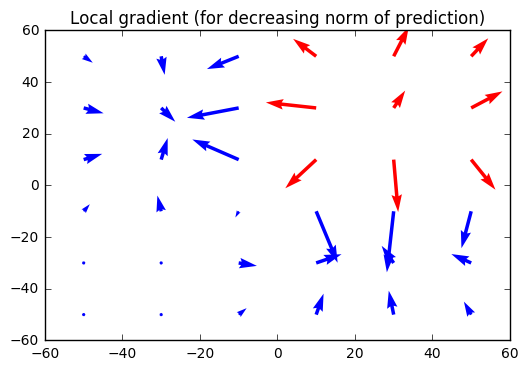

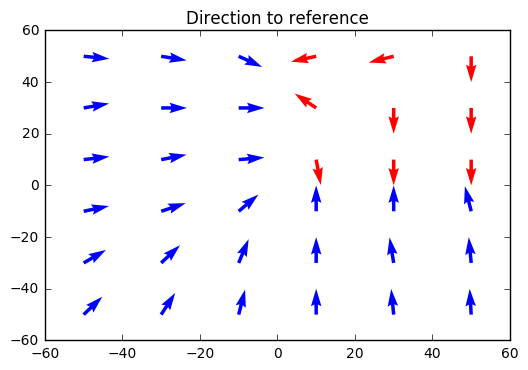

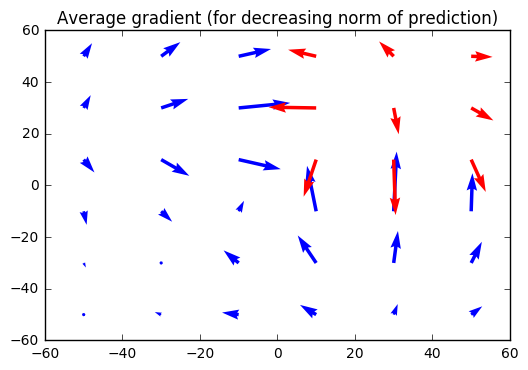

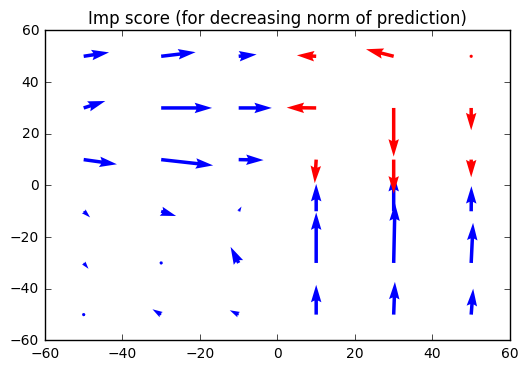

In [23]:
#gradient at each point
grad_per_point = np.array([ish.get_gradient(x) for x in testpoints])
plt.quiver(display_points[:,0], display_points[:,1],
           -grad_per_point[:,0], -grad_per_point[:,1],
           color=[(1,0,0) if x==1 else (0,0,1) for x in np.sign(display_points[:,2])])
plt.title("Local gradient (for decreasing norm of prediction)")
plt.show()

#unit norm direction to reference
dir_to_ref = display_points[:,7:9] - display_points[:,:2]
norm_dir_to_ref = dir_to_ref/np.linalg.norm(dir_to_ref, axis=1)[:,None]
plt.quiver(display_points[:,0], display_points[:,1],
           norm_dir_to_ref[:,0], norm_dir_to_ref[:,1],
           color=[(1,0,0) if x==1 else (0,0,1) for x in np.sign(display_points[:,2])])
plt.xlim(-60, 60)
plt.ylim(-60, 60)
plt.title("Direction to reference")
plt.show()

#avg grad
plt.quiver(display_points[:,0], display_points[:,1],
           -np.sign(display_points[:,2])*display_points[:,5],
           -np.sign(display_points[:,2])*display_points[:,6],
           color=[(1,0,0) if x==1 else (0,0,1) for x in np.sign(display_points[:,2])])
plt.xlim(-60, 60)
plt.ylim(-60, 60)
plt.title("Average gradient (for decreasing norm of prediction)")
plt.show()

plt.quiver(display_points[:,0], display_points[:,1],
           np.sign(display_points[:,2])*display_points[:,3]*np.sign(dir_to_ref[:,0]),
           np.sign(display_points[:,2])*display_points[:,4]*np.sign(dir_to_ref[:,1]),
           color=[(1,0,0) if x==1 else (0,0,1) for x in np.sign(display_points[:,2])])
plt.xlim(-60, 60)
plt.ylim(-60, 60)
plt.title("Imp score (for decreasing norm of prediction)")
plt.show()

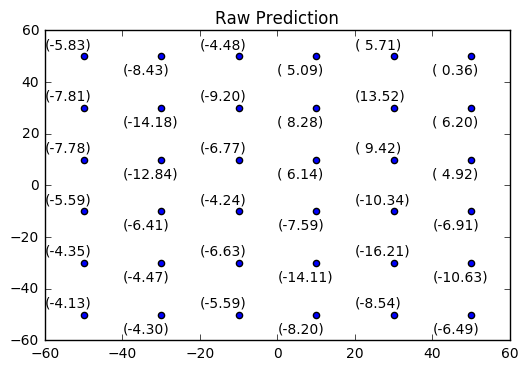

In [24]:
plt.scatter(display_points[:,0], display_points[:,1])
for i in range(display_points.shape[0]):
    x = display_points[i][0]
    y = display_points[i][1]
    raw_pred = display_points[i][2]
    if (x+10)/20 % 2 == 0:
        plt.annotate('(%5.2f)' %(raw_pred), xy=(x,y), xytext=(x-10,y+3))
    else:
        plt.annotate('(%5.2f)' %(raw_pred), xy=(x,y), xytext=(x-10,y-7))
plt.title('Raw Prediction')
plt.show()